# CSC_52081_EP Project

Advanced Machine Learning and Autonomous Agents Project

## Introduction

Reinforcement Learning (RL) has emerged as a robust framework for training autonomous agents to learn optimal behaviors through environmental interactions. This study utilizes the [`CarRacing-v3`](https://gymnasium.farama.org/environments/box2d/car_racing/) environment from Gymnasium, which presents a challenging control task in a racing scenario.

### Environment

The environment features a high-dimensional observation space, represented by a $96 \times 96$ RGB image capturing the car and track, necessitating the use of deep convolutional neural networks (CNNs) for effective feature extraction.

#### Action Space

The action space in CarRacing-v3 supports both continuous and discrete control modes.

In **continuous mode**, the agent outputs three real-valued commands:

- steering (ranging from $-1$ to $+1$)
- gas
- braking

In **discrete mode**, the action space is simplified to five actions:

- do nothing
- steer left
- steer right
- gas
- brake

This dual action representation enables a comprehensive evaluation of various RL algorithms under different control settings.

#### Reward

The reward structure combines a penalty of $-0.1$ per frame and a reward of $+\frac{1000}{N}$ for each new track tile visited, where $N$ is the total number of tiles. This incentivizes the agent to balance exploration (visiting tiles) with efficiency (minimizing frame usage). For example, completing the race after visiting all $N$ tiles in 732 frames yields a reward of $1000 - 0.1 \times 732 = 926.8$ points.

### Objective

The primary objective of this project is to compare RL policies across discrete and continuous action modalities. For discrete control, methods like **Deep Q-Network** (DQN) and **SARSA** are implemented, while continuous control is explored using approaches such as the **Cross-Entropy Method** (CEM), **Self-Adaptive Evolution Strategy** (SA-ES), and policy gradient techniques like **Proximal Policy Optimization** (PPO) and **Soft Actor-Critic** (SAC). This comparative analysis aims to understand the strengths and limitations of each method in handling complex decision spaces.

The high-dimensional visual inputs in `CarRacing-v3` require effective feature extraction, addressed through a tailored CNN architecture. Transitioning between discrete and continuous action representations also demands careful algorithmic design and parameter tuning to ensure stable learning and convergence. While prior studies have often focused on either discrete or continuous action spaces separately, this work adopts a comparative approach, evaluating different agents within the same environment to assess performance under similar conditions.

At this stage, the work outlines the methodology and anticipated challenges, focusing on designing the CNN-based feature extractor, implementing RL algorithms, and establishing a framework for performance comparison. Preliminary findings are yet to be finalized, but the study is expected to provide insights into applying RL in high-dimensional, real-time control tasks. Limitations include the preliminary nature of experiments and the need for further tuning and validation. Future work will involve extensive empirical evaluations, exploring additional policy gradient methods, and refining the network architecture to better handle the complexities of `CarRacing-v3`.

### GitHub

The project's code is available on [GitHub](https://github.com/tr0fin0/ensta_CSC_52081_EP_project), offering a reproducible framework for future investigations and extensions.

## Installation

### Environment

#### WSL, Linux or MacOS

A `Python Virtual Environment` will be used for this project by run the following on a terminal on the project folder:

```bash
sudo apt install python3.10-venv
python3 -m venv env
source env/bin/activate
python3 -m pip install --upgrade pip
python3 -m pip install -r requirements.txt
```

### Imports

In [ ]:
from collections import deque
from ipywidgets import interact
from IPython.display import Video
from pathlib import Path
from tqdm.notebook import tqdm
from typing import cast, List, Tuple, Deque, Optional, Callable
import os
import gymnasium as gym
import gymnasium.wrappers as gym_wrap
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
import random
from PPO import PolicyNetwork, ValueNetwork
from SkipFrame import SkipFrame
from ReplayBuffer import ReplayBuffer
from tensordict import TensorDict
from torchrl.data import TensorDictReplayBuffer, LazyMemmapStorage

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import torch.distributions as dist

### Setup

#### Directories

In [3]:
DIRECTORY_OUTPUT = "output"
DIRECTORY_MODELS = Path(f"{DIRECTORY_OUTPUT}/models/")
DIRECTORY_VIDEOS = Path(f"{DIRECTORY_OUTPUT}/videos/")

if not DIRECTORY_VIDEOS.exists():
    DIRECTORY_VIDEOS.mkdir(parents=True)

if not DIRECTORY_MODELS.exists():
    DIRECTORY_MODELS.mkdir(parents=True)

## Demonstration

In [4]:
VIDEO_DEMO = "CSC_52081_EP_demonstration"
(DIRECTORY_VIDEOS / f"{VIDEO_DEMO}.mp4").unlink(missing_ok=True)

env = gym.make(
    "CarRacing-v3",
    render_mode="rgb_array",
    lap_complete_percent=0.95,
    domain_randomize=False,
    continuous=True
)
env = gym.wrappers.RecordVideo(env, video_folder=str(DIRECTORY_VIDEOS), name_prefix=VIDEO_DEMO)
done = False
observation, info = env.reset()

while not done:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

env.close()

Video(
    DIRECTORY_VIDEOS / f"{VIDEO_DEMO}-episode-0.mp4",
    embed=True,
    html_attributes="controls autoplay loop",
)

c:\ENSTA\Avanced_machine_learning\env-project\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\ENSTA\Avanced_machine_learning\ensta_CSC_52081_EP_project\src\dev\output\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


## Description

only demonstration is right. from below here is only experimental.

### Global Definitions

#### Constants

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set the device to CUDA if available, otherwise use CPU

env = gym.make("CarRacing-v3", 
               render_mode="rgb_array",
               lap_complete_percent=0.95,
               continuous=True)

env = SkipFrame(env, skip=4)
env = gym_wrap.GrayscaleObservation(env)
env = gym_wrap.ResizeObservation(env, shape=(84, 84))
env = gym_wrap.FrameStackObservation(env, stack_size=4)

#### Functions

In [5]:
def plot_learning_curve(rewards):
    plt.plot(rewards)
    plt.xlabel("Episodes")
    plt.ylabel("Cumulative Reward")
    plt.title("Learning Curve")
    plt.show()

def plot_action_heatmap(action_counts):
    plt.imshow(action_counts, cmap="hot", interpolation="nearest")
    plt.colorbar()
    plt.title("Action Heatmap")
    plt.show()

class RewardNormalizer:
    def __init__(self):
        self.mean = 0
        self.var = 1
        self.count = 1e-4  # Avoid division by zero

    def normalize(self, reward):
        self.mean = 0.99 * self.mean + 0.01 * reward
        self.var = 0.99 * self.var + 0.01 * (reward - self.mean) ** 2
        return reward / (np.sqrt(self.var) + 1e-8)  # Avoid small divisor

reward_normalizer = RewardNormalizer()

### PPO

In [16]:
class PPO():
    def __init__(
        self,
        env: gym.Env,
        device: torch.device,
        learning_rate: float = 1e-4,
        gamma: float = 0.99,
        clip_ratio: float = 0.1,
        max_grad_norm: float = 0.5,
        lam: float = 0.97,
        epochs: int=10,
        batch_size: int = 128,
        buffer_size: int = 1000,
    ):
        self.env = env
        self.device = device
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.lam = lam
        self.epochs = epochs
        self.clip_ratio = clip_ratio
        self.max_grad_norm = max_grad_norm
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.old_log_probs = []

        self.policy = PolicyNetwork(
            input_dimensions=self.env.observation_space.shape,
            output_dim=self.env.action_space.shape[0]
        ).to(self.device)

        self.value = ValueNetwork(
            input_dimensions=self.env.observation_space.shape,
            output_dim=1
        ).to(self.device)

        self.optimizer_policy = optim.Adam(self.policy.parameters(), lr=self.learning_rate)
        self.optimizer_value = optim.Adam(self.value.parameters(), lr=self.learning_rate)
        self.buffer = TensorDictReplayBuffer(
            storage=LazyMemmapStorage(self.buffer_size, device=torch.device('cpu'))
        )
        self.updates = 0

    def take_action(self, state):
        mu, std = self.policy(state)
        distribution = dist.Normal(mu, std)
        action = distribution.sample()
        action[:, 0] = torch.clamp(action[:, 0], -1.0, 1.0)  # Steering: [-1, 1]
        action[:, 1:] = torch.clamp(action[:, 1:], 0.0, 1.0) # Gas and brake: [0, 1]
        log_prob = distribution.log_prob(action).sum(dim=-1)  # Compute log probability

        return action, log_prob

    
    def add_sample(self, state, action, reward, next_state, done, log_prob):
        self.buffer.add(
            TensorDict({
                "state": torch.tensor(state),
                "action": torch.tensor(action),
                "reward": torch.tensor(reward),
                "next_state": torch.tensor(next_state),
                "done": torch.tensor(done),
                "log_prob": log_prob.detach(),  # Store log_prob in buffer
            }, batch_size=[])
        )
    
    def get_samples(self, batch_size:int) -> tuple:
        batch = self.buffer.sample(batch_size)
        states = batch.get('state').type(torch.FloatTensor).to(self.device)
        actions = batch.get('action').squeeze().to(self.device)
        rewards = batch.get('reward').squeeze().to(self.device)
        next_states = batch.get('next_state').type(torch.FloatTensor).to(self.device)
        dones = batch.get('done').squeeze().to(self.device)
        log_probs = batch.get('log_prob').squeeze().to(self.device)

        return states, actions, rewards, next_states, dones, log_probs


    def update(self):
        self.updates += 1
        states, actions, rewards, next_states, dones, old_log_probs = self.get_samples(self.batch_size)
        
        next_states = next_states.squeeze(1)
        states = states.squeeze(1)

        value_loss = self.update_value(states, rewards, next_states, dones)
        policy_loss = self.update_policy(states, actions, old_log_probs, rewards, next_states, dones)

        return value_loss, policy_loss

    def update_value(self, states, rewards, next_states, dones):
        with torch.no_grad():
            next_values = self.value(next_states)
            targets = rewards + self.gamma * next_values * (1 - dones.float())

        values = self.value(states)
        value_loss = (values - targets).pow(2).mean()

        self.optimizer_value.zero_grad()
        value_loss.backward()
        nn.utils.clip_grad_norm_(self.value.parameters(), self.max_grad_norm)
        self.optimizer_value.step()

        return value_loss.item()

    def update_policy(self, states, actions, old_log_probs, rewards, next_states, dones):
        mu, std = self.policy(states)
        distribution = torch.distributions.Normal(mu, std)

        log_probs = distribution.log_prob(actions).sum(dim=-1)  # Compute new log probs
        ratio = (log_probs - old_log_probs).exp()  # PPO ratio

        with torch.no_grad():
            next_values = self.value(next_states)
            values = self.value(states)
            advantages = torch.zeros_like(rewards)
            gae = 0
            for t in reversed(range(len(rewards))):
                delta = rewards[t] + self.gamma * next_values[t] * (1 - dones[t].float()) - values[t]
                advantages[t] = gae = delta + self.gamma * self.lam * (1 - dones[t].float()) * gae

        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 1.0 - self.clip_ratio, 1.0 + self.clip_ratio) * advantages
        entropy = distribution.entropy().mean()
        policy_loss = -torch.min(surr1, surr2).mean() - 0.01 * entropy  # Entropy bonus

        self.optimizer_policy.zero_grad()
        policy_loss.backward()
        nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
        self.optimizer_policy.step()

        return policy_loss.item()
    
    def save(self, save_name: str = 'PPO'):
        path = DIRECTORY_MODELS / f"{save_name}_{self.updates}.pt"
        torch.save({
            "policy": self.policy.state_dict(),
            "value": self.value.state_dict(),
            "optimizer_policy": self.optimizer_policy.state_dict(),
            "optimizer_value": self.optimizer_value.state_dict(),
            "learning_rate": self.learning_rate,
        }, path)
        print(f"Model saved to {path} at update {self.updates}")
    
    def load(self, load_name: str):
        path = DIRECTORY_MODELS / f"{load_name}.pt"
        model = torch.load(path)
        self.policy.load_state_dict(model["policy"])
        self.value.load_state_dict(model["value"])
        self.optimizer_policy.load_state_dict(model["optimizer_policy"])
        self.optimizer_value.load_state_dict(model["optimizer_value"])
        self.learning_rate = model["learning_rate"]
        print(f"Model loaded from {path}")

## Train the Model

In [17]:
from plot_reward import plot_reward

EPISODES = 1000

agent = PPO(
    env=env,
    device=device
)

episode_rewards = []
episode_lengths = []
episode_value_losses = []
episode_policy_losses = []

interval_save = 100  # Save the model every X episodes

# Training Loop
for episode in range(EPISODES):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(agent.device)

    episode_reward = 0
    episode_length = 0
    done = False
    value_losses = []
    policy_losses = []

    action, log_prob = agent.take_action(state)  # Convert to numpy
    action = action.squeeze(0).to("cpu").numpy()

    while not done:
        action, log_prob = agent.take_action(state)  
        action = action.squeeze(0).to("cpu").numpy()

        next_state, reward, terminated, truncated, info = env.step(action)
        next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(agent.device)

        episode_reward += reward
        episode_length += 1
        done = terminated or truncated

        reward /= 10
        agent.add_sample(state, action, reward, next_state, done, log_prob) # Store transition

        state = next_state

    # PPO updates after collecting enough samples
    if len(agent.buffer) >= agent.batch_size:
        for _ in range(agent.epochs):  # PPO does multiple updates per cycle
            value_loss, policy_loss = agent.update()
            value_losses.append(value_loss)
            policy_losses.append(policy_loss)

        # Clears buffer
        agent.buffer = TensorDictReplayBuffer(
            storage=LazyMemmapStorage(agent.buffer_size, device=torch.device('cpu')))

    # Save the model periodically
    if episode % interval_save == 0:
        agent.save()

    # Track performance
    episode_rewards.append(episode_reward)
    episode_lengths.append(episode_length)
    episode_value_losses.append(np.mean(value_losses) if value_losses else 0)
    episode_policy_losses.append(np.mean(policy_losses) if policy_losses else 0)

    plot_reward(episode, episode_rewards, episode_length)  # Update reward plot

# Save final model
agent.save()
env.close()

plt.ioff()
plt.show()

Model saved to output\models\PPO_10000.pt at update 10000


<Figure size 640x480 with 0 Axes>

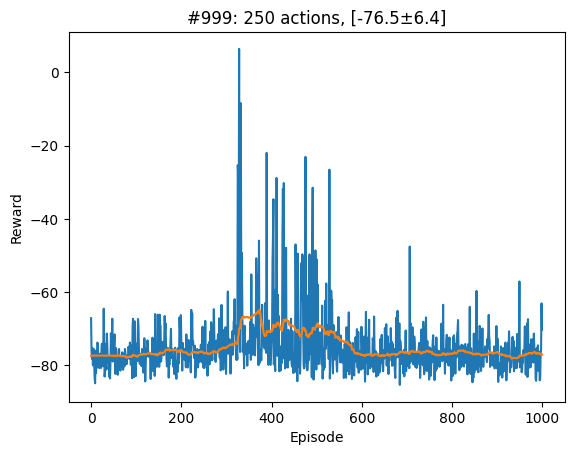

<Figure size 640x480 with 0 Axes>

In [21]:
plot_reward(episode, episode_rewards, episode_length)

In [27]:
plt.plot(episode_value_losses, label="Value Loss")

In [24]:
plt.plot(episode_policy_losses, label="Policy Loss")

In [28]:
print("Value loss mean:", np.mean(episode_value_losses), "std:", np.std(episode_value_losses))

Value loss mean: 0.028679806714039295 std: 0.015493940104889234


In [29]:
print("Value loss mean:", np.mean(episode_policy_losses), "std:", np.std(episode_policy_losses))

Value loss mean: -0.01462731695966795 std: 0.0029133132393721712


## Test it

In [31]:
VIDEO_EVAL = "PPO_EVALUATION"
(DIRECTORY_VIDEOS / f"{VIDEO_EVAL}.mp4").unlink(missing_ok=True)

env = gym.wrappers.RecordVideo(env, video_folder=str(DIRECTORY_VIDEOS), name_prefix=VIDEO_EVAL)

scores = []
seeds = [i for i in range(2)]

# MODEL_ID = "PPO_7890"
# agent.load(load_name=MODEL_ID)
print(agent.updates)


for episode, seed_id in enumerate(seeds):
    score = 0
    action_count = 0

    state, info = env.reset(seed=seed_id)
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(agent.device)
    action, _ = agent.take_action(state)
    action = action.squeeze(0).to("cpu").numpy()
    updating = True

    while updating:
        next_state, reward, terminated, truncated, info = env.step(action)
        next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(agent.device)

        updating = not (terminated or truncated)
        score += reward
        action_count += 1

        state = next_state
        action, _ = agent.take_action(state)
        action = action.squeeze(0).to("cpu").numpy()

    scores.append(score)

    print(f"Score:{score:.2f}, actions: {action_count}")

env.close()

Video(
    DIRECTORY_VIDEOS / f"{VIDEO_EVAL}-episode-0.mp4",
    embed=True,
    html_attributes="controls autoplay loop",
)

c:\ENSTA\Avanced_machine_learning\env-project\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\ENSTA\Avanced_machine_learning\ensta_CSC_52081_EP_project\src\dev\output\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


10000
Score:-81.19, actions: 250
Score:-52.73, actions: 250
